# AFMFIT TUTORIAL

## Import the AFM images

The first step is to import the AFM images, the supported file type are TIFF and ASD. When importing, TIFF files, make sure to set up the sampling rate (vsize) and the Z-scale (unit)

In [1]:
%matplotlib TkAgg
import os
from afmfit.image import ImageSet

# import the example images contained in the tiff
imgs = ImageSet.read_tif(os.getcwd() + "/examples_data/ef2_afm.tiff", vsize=7.0, unit="nm")

# displays the images in a separate window
imgs.show()

Read 1 images of size 1000 x 1000 pix at 0.70 nm/pix 


## Preprocessing

Optionnaly, a preprocessing step can be performed to align the zero of the Z-scale of each image in the set, and crop Z-values above the range of interest.

In [2]:
imgs.set_min(0.0)
imgs.set_max(80.0)
imgs.normalize_mode()

imgs.show()

## Pick the particles

In this step, we extract the particles from the image set.

In [5]:
from afmfit.gui import AFMfitPicker

# Pick particles with the GUI
picker = AFMfitPicker(imgs)
picker.view()

# Extract the particles
particles = picker.get_particles()

Frame 0: 100 features
Extracting particles ...


## Import the PDB

Read the PDB file to be used as initial model 

In [6]:
from afmfit.pdbio import PDB

# read the PDB file
pdb = PDB(os.getcwd() + "/examples_data/ef2.pdb")

# center the atoms around the coordinate 0,0,0
pdb.center()

print("The PDB file contains %i atoms"%pdb.n_atoms)

# Show in ChimeraX (comment this line if Chimerax is not installed)
pdb.viewChimera()

The PDB file contains 6215 atoms


## Calculate NMA

Performs Normal Mode Analysis using NOLB

In [7]:
from afmfit.nma import NormalModesRTB

# Set the desired number of modes and cutoff (in Angstrom) for the elastic network model (higher cutoff= more rigid)
nma = NormalModesRTB.calculate_NMA(pdb,nmodes=3, cutoff=8.0)

# Show in ChimeraX (comment this line if Chimerax is not installed)
# press on the "play" button (bottom right) to diplay the desired mode. Switch between models in the model panel.
nma.viewChimera(amp= 1000)

*******************************************************************
*-----------------------------------------------------------------*
*-----------NOLB : a Non-Linear rigid block NMA method------------*
*----------Authors: Alexandre Hoffmann & Sergei Grudinin----------*
*---------Copyright (c): UGA/CNRS Grenoble, France, 2023.---------*
*-------- e-mail: sergei.grudinin@univ-grenoble-alpes.fr ---------*
*---- http://team.inria.fr/nano-d/software/nolb-normal-modes/ ----*
*-----------------------------------------------------------------*
*******************************************************************
Hostname......................................................... : ljk-ad-77
Run at........................................................... : Mon Aug 19 11:55:57 2024
Command-line arguments........................................... : /home/AD/vuillemr/miniconda/lib/python3.11/site-packages/afmfit/nolb/NOLB /tmp/tmpu0kdcp5q/.pdb -o /tmp/tmpu0kdcp5q/ -s 0 -n 3 --format 3 -c 8.000000

## Set the AFM image simulator

The fitting compares AFM-like images of the initial model to AFM experiments.
This section defines the parameters of the AFM simulator.

In [11]:
%matplotlib tk
from afmfit.simulator import AFMSimulator
from afmfit.viewer import viewAFM

# Set the parameters to simulate the pseudo-AFM images used for the fitting
# Implements eq.1
#  - sigma controls the smoothness
#  - cutoff (angstrom) above which the computation is ignored. Decrease the computational time for smaller values.
#  - beta can be kept to 1.0 (gamma in eq. 1)
simulator = AFMSimulator(size=particles.sizex, 
                         vsize=particles.vsize, 
                         sigma=3.2)

# Create an image of the PDB that have been loaded
image = simulator.pdb2afm(pdb)

# show the generated image vs the AFM image
viewAFM([image, particles.imgs[0]])


(<Figure size 1000x400 with 4 Axes>,
 array([<Axes: xlabel='nm', ylabel='nm'>, <Axes: xlabel='nm', ylabel='nm'>],
       dtype=object))

## Rigid Fitting

The rigid fitting performs a global alignment of the PDB with the images

In [13]:
# import the fitter
from afmfit.fitting import Fitter
from afmfit.utils import get_flattest_angles
import numpy as np

# defines the fitter
fitter = Fitter(pdb=pdb, imgs=particles.imgs, simulator=simulator)

# restrict the fitting to flat orientations only
flat_orientations = get_flattest_angles(pdb=pdb, percent=20.0, angular_dist=10)

# Performs the rigid fitting - implements eq.2-5
fitter.fit_rigid(n_cpu=16, 
                 angular_dist=10, 
                 verbose=True, 
                 zshift_range=np.linspace(-10,10,5),
                 true_zshift=False,
                 init_angles= flat_orientations
)

# save the fitting on the disk
fitter.dump(os.getcwd() +'/examples_data/rigid.pkl')

# show the results
fitter.show()

Projection Matching: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


## Flexible fitting

Flexibly aligns the model with the images

In [14]:
# Flexible fitting - impelments eq. 9-19
fitter.fit_flexible(n_cpu=16,          # number of CPU
                    nma=nma,           # Normal mode analysis object
                    n_best_views=10,   # Number of rigid views to test as initial pose. 
                    dist_views=15,     # Angular distance (°) between the n_best_views to test.
                    n_iter=10,         # Number of iteration of the algorithm. 10 is typically enough, 
                    lambda_r=5**2,       # 
                    lambda_f=5**2, 
                    verbose=True)

fitter.dump(os.getcwd() +'/examples_data/flexible.pkl')

Flexible Fitting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


In [15]:
fitter = Fitter.load(os.getcwd() +'/examples_data/flexible.pkl')

fitter.show()

## Conformational Space with PCA

Calculation fo the conformational space from the fitted models. In this synthetic example, the conformational space describe a circle in the two first normal modes.

/home/AD/vuillemr/miniconda/lib/python3.11/site-packages/afmfit/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/AD/vuillemr/miniconda/lib/python3.11/site-packages/afmfit/utils.py:142: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


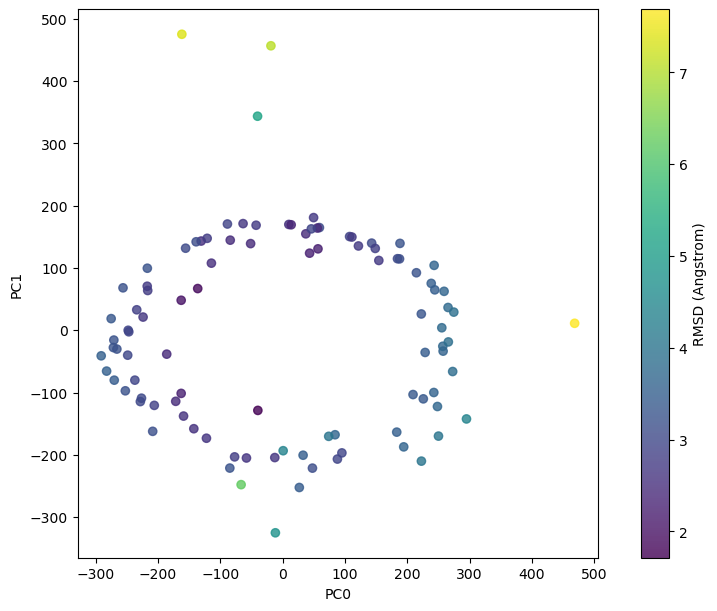

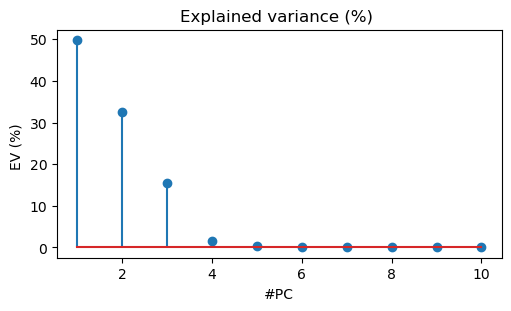

In [19]:
from afmfit.utils import DimRed
%matplotlib inline

pca =DimRed.from_fitter(fitter=fitter, method="pca", n_components=10)

pca.show(ax=[0,1], cval=fitter.get_best_rmsd(), cname="RMSD (Angstrom)" )
pca.show_pca_ev()
